<a href="https://colab.research.google.com/github/pvanand07/Retail-Sales-Prediction-Regression/blob/master/1_2_RS_Decision_Tree%2BRandom_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import Dataset

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Load_Dataset():
  df = pd.read_csv('/content/drive/MyDrive/Almabetter/Almabetter Projects/Data & Resources/Rossmann Stores Data.csv')
  df2 = pd.read_csv('/content/drive/MyDrive/Almabetter/Almabetter Projects/Data & Resources/store.csv')
  return df,df2
def merge_data(df,df2):
  df.set_index('Store', inplace=True)
  df2.set_index('Store', inplace=True)
  df_m = df.join(df2, on='Store')
  return df_m
df,df2 = Load_Dataset()
df_m = merge_data(df,df2)

### 2. Data Cleaning

In [ ]:
# Selecting only the rows with Open = 1
df_m2 = df_m[df_m['Open'] == 1].drop('Open', axis=1).copy()

# Converting Date to Datetime for analysis and feature engineering
df_m2['Date'] = pd.to_datetime(df_m2['Date'])

# We can also convert object Dtype to category for reduced memory usage
for col in df_m2.select_dtypes('object').columns:
  df_m2[col] = df_m2[col].astype('category')

# Replace all variations of "0" with a single representation
df_m2['StateHoliday'] = df_m2['StateHoliday'].replace(['0', 0], '0')

### 3. Data Preprocessing

In [ ]:
# Data pre-processing
def cap_outliers(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    cleaned_df = df.copy()

    # Iterate over numerical columns
    for column in cleaned_df.select_dtypes(include=np.number):
        # Calculate the 99th percentile value
        cap_value = cleaned_df[column].quantile(0.95)

        # Cap outliers to the 99th percentile value
        cleaned_df[column] = np.where(cleaned_df[column] > cap_value, cap_value, cleaned_df[column])

    return cleaned_df

def pre_processing2(df_m):

  target_col = 'Sales'
  df_c = df_m.drop_duplicates().copy()
  df_c = df_c.dropna()#.sample(n = 5000, random_state = 42)
  #df_c = df_c.sample(n = 5000, random_state = 42)

  # Generate  week_number, month and year columns from datetime
  df_c['week_number'] = (df_c['Date']).dt.week
  df_c['month'] = (df_c['Date']).dt.month
  df_c['year'] = (df_c['Date']).dt.year
  df_c.drop(['Date'], axis=1, inplace=True)#,'Customers'

  df_c = cap_outliers(df_c)


  # Separate features and target
  X = df_c.drop(target_col, axis=1)
  y = df_c[target_col]

  # Perform one-hot encoding for categorical features
  categorical_features = X.select_dtypes(include='category').columns.tolist()
  X_encoded = pd.get_dummies(X, columns=categorical_features)


  return X_encoded,y

In [ ]:
X,y= pre_processing2(df_m2)
X.describe()

,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
count,267812.000000,267812.000000,267812.000000,267812.000000,267812.000000,267812.000000,267812.000000,267812.0,267812.000000,267812.000000,...,267812.000000,267812.0,267812.000000,267812.000000,267812.000000,267812.0,267812.000000,267812.000000,267812.000000,267812.000000
mean,3.509156,658.462825,0.446799,0.190193,4155.145102,7.188464,2008.169630,1.0,21.860779,2011.832244,...,0.549173,0.0,0.130879,0.319948,0.582431,0.0,0.417569,0.217414,0.609256,0.173331
std,1.713761,246.013467,0.497162,0.392454,4840.393380,3.249393,7.384723,0.0,13.129778,1.637826,...,0.497577,0.0,0.337269,0.466457,0.493159,0.0,0.493159,0.412487,0.487918,0.378533
min,1.000000,0.000000,0.000000,0.000000,40.000000,1.000000,1900.000000,1.0,1.000000,2009.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,479.000000,0.000000,0.000000,600.000000,4.000000,2005.000000,1.0,13.000000,2011.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.000000,614.000000,0.000000,0.000000,2230.000000,7.000000,2009.000000,1.0,18.000000,2012.000000,...,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,5.000000,799.000000,1.000000,0.000000,5630.000000,10.000000,2012.000000,1.0,37.000000,2013.000000,...,1.000000,0.0,0.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000
max,6.000000,1211.000000,1.000000,1.000000,17110.000000,12.000000,2014.000000,1.0,40.000000,2014.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### Stats Model Results

### Model 2: Decision Tree(sklearn)

In [ ]:
df_m2.columns

Index(['DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Assuming `pre_processing2` returns X_train, X_test, y_train, y_test
X,y = pre_processing2((df_m2))#.drop(['Customers'], axis=1)))#.drop(['Promo2','Promo2SinceYear'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the scaler and fit/transform X_train and X_test

scaler = MinMaxScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Apply square root transformation to y_train and y_test
y_train_s = np.sqrt(y_train)
y_test_s = np.sqrt(y_test)

stats = {}

# Perform regression analysis
X = X_train_s
y = y_train_s
#regressor = DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=15, random_state=0)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X, y)
y_pred = regressor.predict(X_test_s)

In [ ]:
print(regressor.score(X, y))
print(regressor.score(X_test_s, y_test_s))

0.9960095559974053
0.9720660671115722


In [ ]:
regressor.feature_importances_

array([9.98888255e-03, 7.28273992e-01, 4.88970036e-02, 1.22920439e-03,
       5.45501868e-02, 1.56811845e-02, 1.97402908e-02, 0.00000000e+00,
       1.94134862e-02, 1.15755409e-02, 7.13597041e-03, 4.00508396e-03,
       4.37091361e-03, 2.03884285e-05, 1.41005698e-05, 1.76176336e-07,
       9.89075686e-08, 1.07900716e-03, 0.00000000e+00, 1.50719025e-03,
       5.73026706e-02, 4.48121154e-03, 0.00000000e+00, 4.56122044e-03,
       2.39116717e-03, 2.62123167e-03, 1.15979773e-03])

In [ ]:
pd.DataFrame(regressor.feature_importances_, X_train.columns, columns=['Coefficient']).sort_values('Coefficient', ascending=False)

,Coefficient
Customers,7.282740e-01
StoreType_d,5.730267e-02
CompetitionDistance,5.455019e-02
Promo,4.889700e-02
CompetitionOpenSinceYear,1.974029e-02
Promo2SinceWeek,1.941349e-02
CompetitionOpenSinceMonth,1.568118e-02
Promo2SinceYear,1.157554e-02
DayOfWeek,9.988883e-03
week_number,7.135970e-03


In [ ]:
pd.DataFrame(y_pred).describe()
pd.DataFrame(y_test_s).describe()

,Sales
count,53563.000000
mean,78.709717
std,14.957155
min,0.000000
25%,68.102863
50%,77.942286
75%,88.932559
max,107.459062


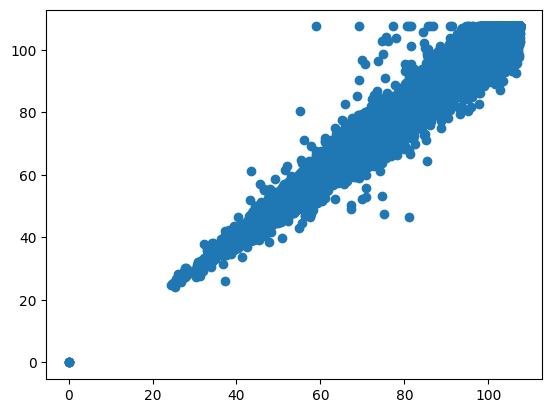

In [ ]:
plt.scatter(y_pred,y_test_s)

Text(0, 0.5, 'residuals')

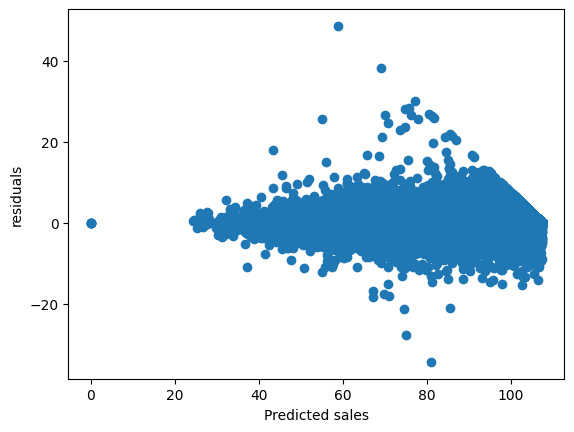

In [ ]:
### Heteroscadacity
plt.scatter(y_pred,y_test_s-y_pred)
plt.xlabel('Predicted sales')
plt.ylabel('residuals')

# 3. Feature Selection and Engineering

In [ ]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

def calculate_vif(df):
    # Select numerical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64'])

    # Replace infinite values with NaN
    numerical_columns.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values
    numerical_columns.dropna(inplace=True)

    # Remove duplicates
    numerical_columns = numerical_columns.loc[:,~numerical_columns.columns.duplicated()]

    # Create a DataFrame to store VIF results
    vif_data = pd.DataFrame()
    vif_data['Variable'] = numerical_columns.columns
    vif_data['VIF'] = [vif(numerical_columns.values, i) for i in range(numerical_columns.shape[1])]

    return vif_data.sort_values(by='VIF', ascending=False)

calculate_vif(df_m2.drop(['Sales'], axis=1))

,Variable,VIF
7,Promo2,1.573677e+06
2,Promo,1.153423e+00
1,Customers,1.119583e+00
0,DayOfWeek,1.117165e+00
4,CompetitionDistance,1.059632e+00
9,Promo2SinceYear,1.037353e+00
3,SchoolHoliday,1.020993e+00
8,Promo2SinceWeek,1.019017e+00
6,CompetitionOpenSinceYear,1.010080e+00
5,CompetitionOpenSinceMonth,1.009137e+00


In [ ]:
calculate_vif((df_m2).drop(['Promo2','Promo2SinceYear','Sales','CompetitionOpenSinceYear'], axis=1))

,Variable,VIF
1,Customers,5.140540
5,CompetitionOpenSinceMonth,4.461682
0,DayOfWeek,4.066374
6,Promo2SinceWeek,3.218630
2,Promo,2.017833
4,CompetitionDistance,1.600253
3,SchoolHoliday,1.230049


In [ ]:
!unzip /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
